In [1]:
import sys
sys.path.insert(0, "..")

from sf_runoff import daily_climatology, spatial_avg_daily_input, spatial_stats_daily_input, compute_anomalies, create_it_matrix
from nested_CV import SVR_nested_CV_gridsearch, SVR_PCA_nested_CV_gridsearch
from test import evaluate_prediction, plot_prediction, plot_anomalies
from test import nested_CV_PCA_SVR_predict, nested_CV_SVR_predict
from classic_CV_predict import classic_CV_PCA_SVR_predict, classic_CV_SVR_predict


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA


import matplotlib.pyplot as plt
import os
import pdb
import seaborn as sns
nb_name=''

In [5]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [6]:
path=r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\Documents\conda\daily_input\\'
daily_input = pd.read_csv(path+nb_name[:-6]+'.csv', index_col=0, parse_dates=True)

In [7]:
daily_input

,T,T5,T25,T75,T95,E,E5,E25,E75,E95,...,P5,P25,P75,P95,S,S5,S25,S75,S95,Q
2008-01-01,269.308016,261.012363,266.208440,273.242242,274.031719,0.145166,-0.140680,0.025382,0.238905,0.504348,...,0.000000,0.000379,0.008562,0.017541,34.740319,0.0,0.0,55.5,150.1,NaN
2008-01-02,268.729557,259.505140,265.256509,273.230760,273.866758,0.158414,-0.011300,0.077213,0.226564,0.389530,...,0.034285,0.293418,1.796000,2.352978,35.521640,0.0,1.0,55.5,151.0,NaN
2008-01-03,268.908129,260.679015,265.737817,272.875393,273.509308,0.083467,-0.123656,-0.011927,0.162842,0.323870,...,1.239234,3.777909,7.051325,9.003770,40.109339,2.9,6.0,57.5,154.1,NaN
2008-01-04,271.325506,264.701693,269.068500,274.036019,275.116766,0.128435,-0.047397,0.009692,0.202108,0.474095,...,2.697849,6.672662,11.874834,15.131939,45.421412,0.0,10.0,65.5,159.1,NaN
2008-01-05,273.568029,267.732019,271.804111,275.663176,276.751249,0.177931,0.016011,0.073537,0.220043,0.501938,...,1.346335,1.852174,7.176791,10.990943,46.015945,0.0,7.0,68.5,169.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,274.235013,267.051241,271.214395,277.382782,278.628245,0.287854,-0.042451,0.078235,0.447026,0.851777,...,0.001711,0.025704,2.258641,11.907705,75.580866,0.0,0.0,141.5,373.1,256.0
2019-12-28,272.231513,264.314933,269.043971,275.819661,277.080511,-0.006637,-0.214345,-0.103542,0.061470,0.316019,...,0.000000,0.000005,0.000352,0.001923,75.569476,0.0,0.0,141.5,373.1,250.0
2019-12-29,273.513335,267.607966,271.659057,275.588458,277.072879,0.136361,-0.154544,-0.070681,0.295577,0.742069,...,0.000000,0.000082,0.001172,0.003221,75.503417,0.0,0.0,141.5,373.0,226.0
2019-12-30,273.224404,267.895612,271.765300,275.034397,276.341721,0.062962,-0.175727,-0.084043,0.192312,0.421527,...,0.000000,0.000662,0.014715,0.032434,75.451025,0.0,0.0,141.5,373.0,217.0


In [8]:
t_unit=10

#define the possible parameters value (where Gridsearch is applied)

C_range=np.logspace(-1.5, 0.5, 10)
epsilon_range=np.logspace(-2.2, -0.2, 4)
#n_range = [17, 50, 200]
components_range = [5*4*36]
#do not enlarge t_range for now
t_range=[36]
t_length=t_range[0]
n_splits=4
test_size=365

Fitting 1 folds for each of 40 candidates, totalling 40 fits
Fitting 1 folds for each of 40 candidates, totalling 40 fits
Fitting 1 folds for each of 40 candidates, totalling 40 fits
Fitting 1 folds for each of 40 candidates, totalling 40 fits

C=3.1622776601683795
eps=0.00630957344480193


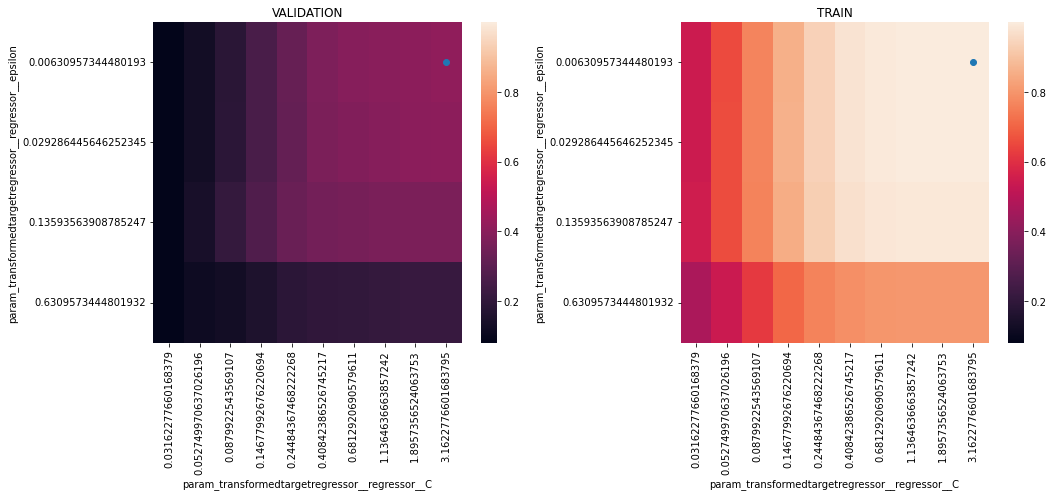

In [5]:
C, eps = SVR_nested_CV_gridsearch(daily_input, C_range,epsilon_range, t_range,t_unit,n_splits,test_size)
print(f'C={C}')
print(f'eps={eps}')

In [12]:
C_range=np.logspace(0.5,2.2, 10)
epsilon_range=np.logspace(-3.5,-2.2, 4)

Fitting 1 folds for each of 40 candidates, totalling 40 fits
Fitting 1 folds for each of 40 candidates, totalling 40 fits
Fitting 1 folds for each of 40 candidates, totalling 40 fits
Fitting 1 folds for each of 40 candidates, totalling 40 fits

C=42.986623470822785
eps=0.00031622776601683794


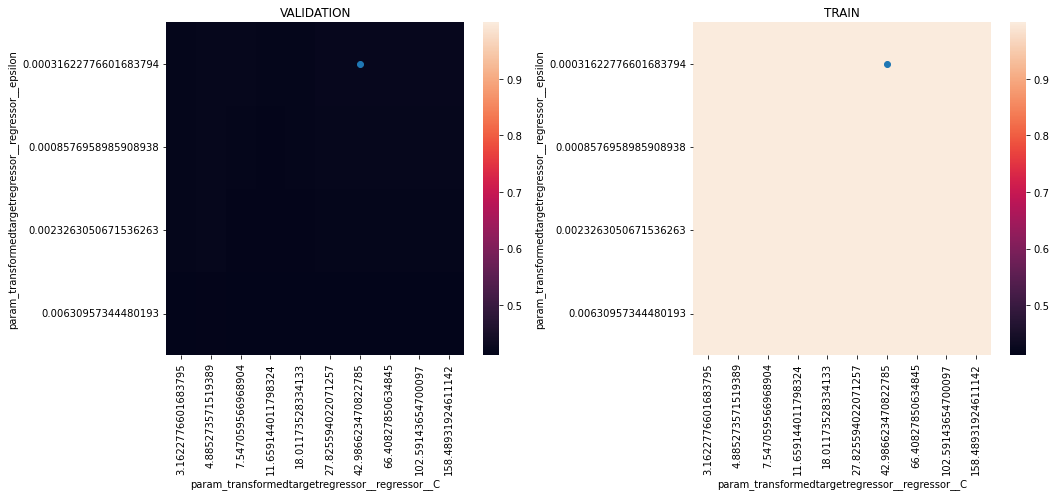

In [7]:
C, eps = SVR_nested_CV_gridsearch(daily_input, C_range,epsilon_range, t_range,t_unit,n_splits,test_size)
print(f'C={C}')
print(f'eps={eps}')

In [13]:
C_range=np.logspace(2,3.2, 10)
epsilon_range=np.logspace(-4.2, -3.2, 4)

Fitting 1 folds for each of 40 candidates, totalling 40 fits
Fitting 1 folds for each of 40 candidates, totalling 40 fits
Fitting 1 folds for each of 40 candidates, totalling 40 fits
Fitting 1 folds for each of 40 candidates, totalling 40 fits

C=100.0
eps=6.309573444801929e-05


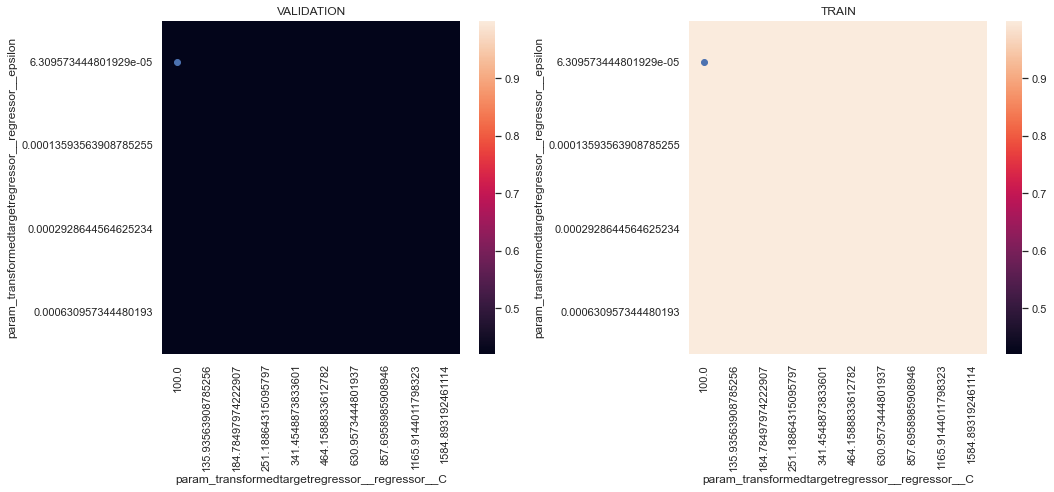

In [14]:
C, eps = SVR_nested_CV_gridsearch(daily_input, C_range,epsilon_range, t_range,t_unit,n_splits,test_size)
print(f'C={C}')
print(f'eps={eps}')

In [9]:
C=100.0
eps=6.309573444801929e-05

In [10]:
radius_for_ensemble = 1
predictions = nested_CV_SVR_predict(daily_input, C, eps, t_length,t_unit, n_splits, test_size, radius_for_ensemble)

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

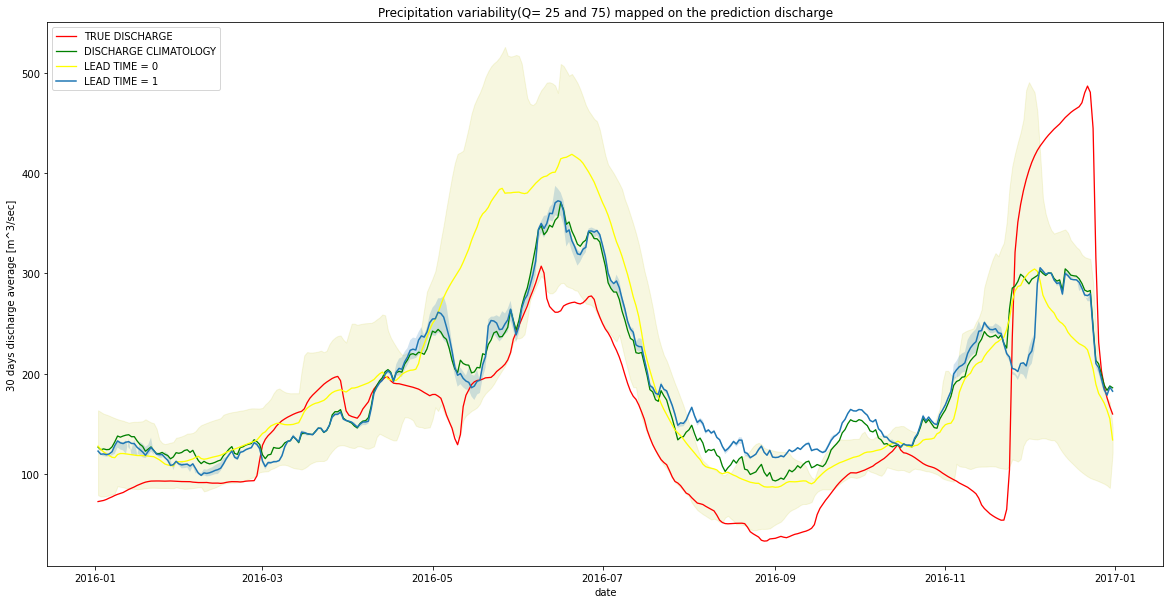

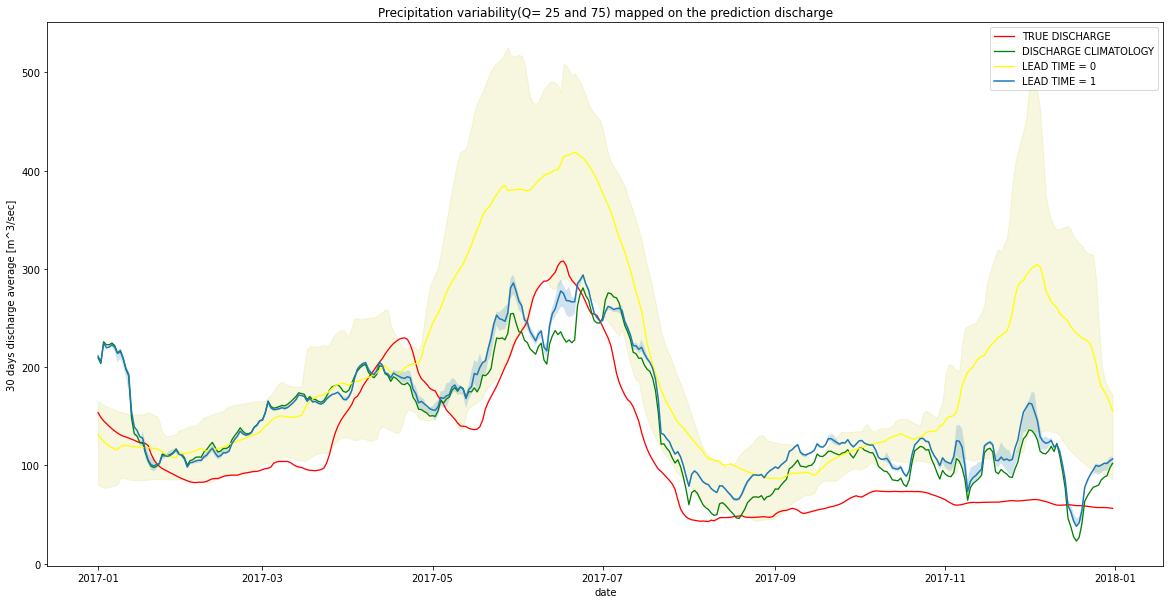

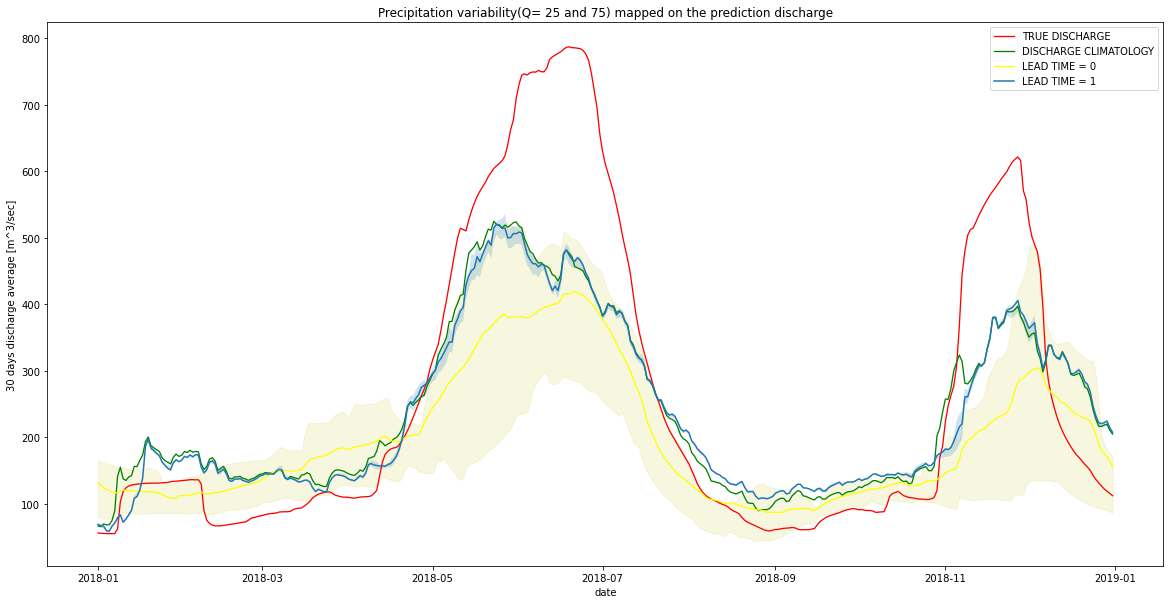

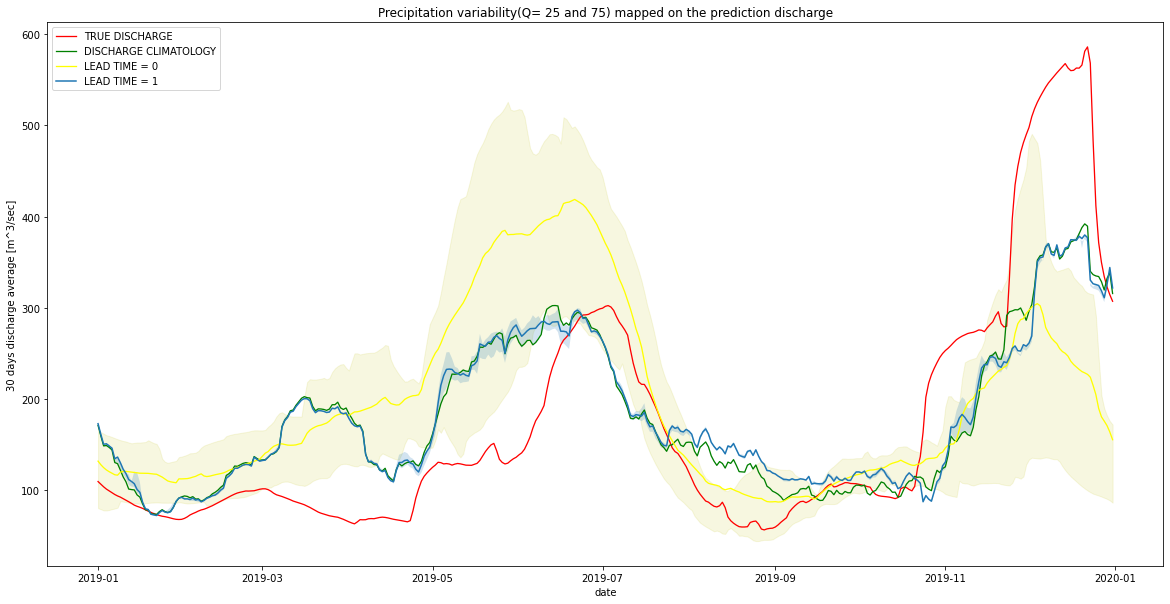

In [11]:
#predictions=pd.read_csv('tial.csv',date_parser=True)
plot_prediction(predictions)


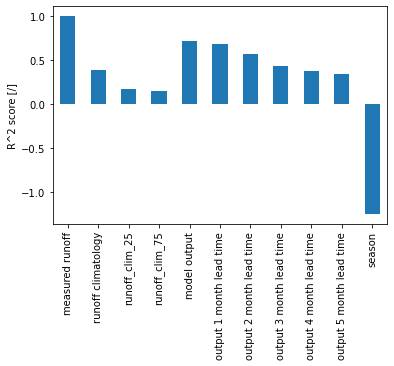

In [12]:
from test import evaluate_class, evaluate_class_season
clas=evaluate_class_season(predictions)
clas.index=np.repeat(nb_name[:-6],4)
clas.to_csv('class_res.csv', mode='a', header=False)

r=pd.DataFrame(evaluate_prediction(predictions)).transpose()
r['STAT_CODE']=(nb_name[:-6])
r.index=r.STAT_CODE
r.drop(columns=['season','runoff_clim_25','runoff_clim_75','STAT_CODE'],inplace=True)
r.to_csv('r_res.csv',mode='a',header=False)

measured runoff             1.000000
runoff climatology          0.387626
runoff_clim_25              0.169462
runoff_clim_75              0.148944
model output                0.715286
output 1 month lead time    0.684419
output 2 month lead time    0.576766
output 3 month lead time    0.433400
output 4 month lead time    0.372325
output 5 month lead time    0.347964
season                     -1.252920
dtype: float64

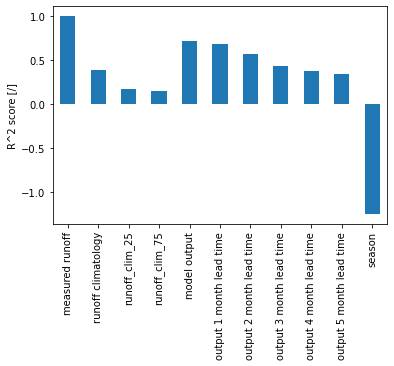

In [13]:
evaluate_prediction(predictions)

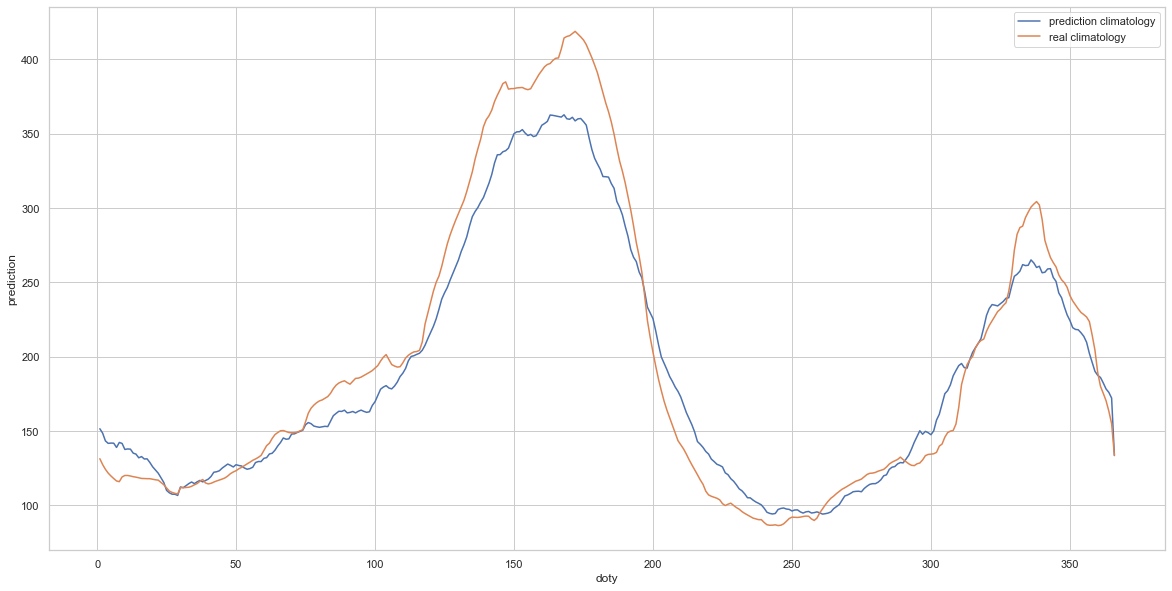

In [14]:
predictions_for_clim = classic_CV_SVR_predict(daily_input, C, eps, t_length,t_unit, n_splits)
climatologies =predictions_for_clim.groupby(by=predictions_for_clim.index.day_of_year).mean().loc[:,['prediction','true_runoff']]
climatologies['doty']=climatologies.index

sns.set_theme(style="whitegrid")
ax,fig=plt.subplots(figsize=(20,10))
sns.lineplot(data=climatologies,x='doty',y='prediction',label='prediction climatology')
sns.lineplot(data=climatologies,x='doty',y='true_runoff',label='real climatology')
plt.legend()

In [15]:
###overprediction for autumn/low

In [16]:
from db_insert import insert
insert(nb_name[:-6],predictions_for_clim)

In [17]:
##develop model savior

from sklearn.svm import SVR, LinearSVR
from sf_runoff import create_it_matrix
from joblib import dump, load

it_matrix=create_it_matrix(daily_input,t_length,t_unit).astype('float32')

X = it_matrix.drop(columns='Q')
y = it_matrix['Q']
svr_estimator = SVR(kernel='rbf', gamma='scale', cache_size=15000,C=C,epsilon=eps)

svr_estimator = make_pipeline(StandardScaler(),
                              TransformedTargetRegressor(regressor=svr_estimator, transformer=StandardScaler()))

svr_estimator.fit(X, y)

path='models/'+nb_name[:-6]+'.joblib'

dump(svr_estimator, path)

['models/ADO_DSC_ITC1_0020.joblib']